In [14]:

# Loading libraries for the course
from skimage import io as ski_io
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
import skimage as ski
from matplotlib import animation            # Module to plot animations
from skimage.filters import difference_of_gaussians
from skimage import io, measure               # Module from skimage
from cellpose import models

<font size="6">Cytoplasm</font>


In [4]:
# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

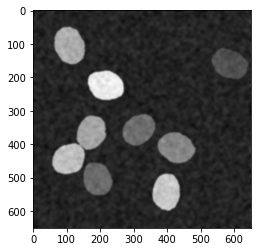

In [6]:
# Select the appropriate frame and color channel
selected_frame = 4
selected_color_channel = 1
img_to_analyze = img[selected_frame, :, :, selected_color_channel]
plt.imshow(img_to_analyze, cmap='gray')
plt.show()

In [11]:
# Initialize Cellpose model for cytoplasm detection
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

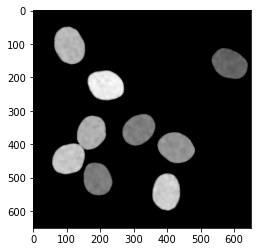

In [12]:
# Apply the cytoplasm mask to the original image
img_bin_cyto = img_to_analyze * (masks_cyto > 0.5)

# Plotting the masked cytoplasm image
plt.imshow(img_bin_cyto, cmap='gray')
plt.show()

In [15]:
# Prepare data for the cytoplasm DataFrame
data_cyto = []
for cell_id in np.unique(masks_cyto):
    if cell_id == 0:
        continue  # skip the background

    mask = masks_cyto == cell_id
    sum_pix_intensity = img_to_analyze[mask].sum()
    cell_sizes = np.sum(mask)

    data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])
print(df_cyto)

   time  cell_ID  sum_pix_intensity_cyto  cell sizes
0     4        1                  940770        8167
1     4        2                  479678        7425
2     4        3                 1162659        7859
3     4        4                  574549        7092
4     4        5                  776694        6984
5     4        6                  736931        7816
6     4        7                  908015        7237
7     4        8                  534028        6718
8     4        9                  960991        7461


<font size="6">Nucleus</font>


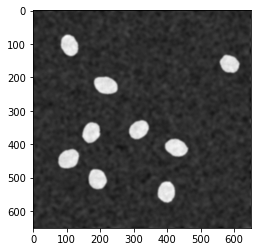

In [17]:
# Select the appropriate frame and color channel
selected_frame = 4
selected_color_channel = 0
img_to_analyze = img[selected_frame, :, :, selected_color_channel]
plt.imshow(img_to_analyze, cmap='gray')
plt.show()

In [18]:
# Initialize Cellpose model for cytoplasm detection
model_nuc = models.Cellpose(gpu=False, model_type='cyto')
masks_nuc, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

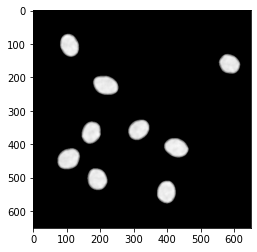

In [19]:
# Apply the cytoplasm mask to the original image
img_bin_nuc = img_to_analyze * (masks_nuc > 0.5)

# Plotting the masked cytoplasm image
plt.imshow(img_bin_nuc, cmap='gray')
plt.show()

In [21]:
# Prepare data for the cytoplasm DataFrame
data_nuc = []
for cell_id in np.unique(masks_nuc):
    if cell_id == 0:
        continue  # skip the background

    mask = masks_nuc == cell_id
    sum_pix_intensity = img_to_analyze[mask].sum()
    cell_sizes = np.sum(mask)

    data_nuc.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

df_nuc = pd.DataFrame(data_nuc, columns=['time', 'cell_ID', 'sum_pix_intensity_nucleus', 'cell sizes'])
print(df_nuc)

   time  cell_ID  sum_pix_intensity_nucleus  cell sizes
0     4        1                     463780        3024
1     4        2                     431099        2886
2     4        3                     525242        3454
3     4        4                     455995        3012
4     4        5                     457902        3033
5     4        6                     492930        3224
6     4        7                     506745        3373
7     4        8                     468725        3104
8     4        9                     468055        3033


<font size="6">mRNA</font>
